In [ ]:
import numpy as np
from google.colab import drive
import warnings
from pathlib import Path
import pandas as pd
import os
import imutils
import dlib
from google.colab.patches import cv2_imshow
import cv2
import imageio
from PIL import Image
from imutils import face_utils
import time
from keras.utils import np_utils, generic_utils
import shutil
from skimage.transform import resize
from sklearn.utils import shuffle
from skimage.io import imread, imsave, imshow
import tensorflow
import keras
from keras import layers
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential, load_model
from keras.layers import Input,Activation, Bidirectional,ConvLSTM3D,ConvLSTM2D,ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape,BatchNormalization, ConvLSTM2D,GlobalMaxPooling2D
from keras.utils import plot_model
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import tqdm
from tqdm.notebook import tqdm
from keras.applications.vgg16 import VGG16
warnings.filterwarnings("ignore")

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
t1 = time.time()
!unzip '/content/gdrive/MyDrive/Colab Notebooks/miracl.zip' > /dev/null
t2 = time.time()
print(f"Time taken to unzip: {t2-t1} secs")

Time taken to unzip: 107.31625032424927 secs


In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

words = ['Begin','Choose','Connection','Navigation','Next', 'Previous', 'Start','Stop','Hello','Web']
phrases = ["Stop navigaton","Excuse me","I am sorry","Thank you",'Good bye','I love this game','Nice to meet you','You are welcome','How are you?','Have a good time']
phrases_di = {i:phrases[i] for i in range(len(phrases))}


words_di = {i:words[i] for i in range(len(words))}

unseen_test = ['F04']
unseen_validation = ['F07','M02']


starting_path = '/content/dataset/dataset'


people = ['F01','F02','F04','F05','F06','F07','F08','F09','F10','F11','M01','M02','M04','M07','M08']
data_types = ['phrases']
folder_nums = ['01','02','03','04','05','06','07','08','09','10']
instances = ['01','02','03','04','05','06','07','08','09','10']
image_nums = ['color_001','color_002','color_003','color_004','color_005','color_006','color_007','color008','color_009','color_010','color_11','color_12','color_13']

In [ ]:
people = ['F01']
unseen_test = ['07','09','10']
train = ['10']
unseen_validation = ['08']


In [ ]:
def crop_and_save():
    MAX_HEIGHT = 100
    MAX_WIDTH = 100
    max_seq_length = 10
    t1 = time.time()
    hog_face_detector = dlib.get_frontal_face_detector()
    dlib_facelandmark = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

    for person in people:
        tx1 = time.time()
        for data_type in data_types:
            for word_index,folder in enumerate(tqdm(folder_nums)):
                for instance in instances:
                    sequence = []
                    for image in image_nums:
                        path = starting_path + '/' + person + '/' + data_type + '/' + folder + '/'+instance + '/' + image + '.jpg'
                        #print(path)

                        if(os.path.exists(path) and path.__contains__('color')):
                            #print(path)
                            frame = cv2.imread(path)
                            
                            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                            #gray = frame
                            x_arr = []
                            y_arr = []
                            gray = imutils.resize(gray, width=500)
                            copy = gray.copy()
                            faces = hog_face_detector(gray)
                            for face in faces:

                                face_landmarks = dlib_facelandmark(gray, face)

                                for n in range(48, 68):
                                    x = face_landmarks.part(n).x
                                    y = face_landmarks.part(n).y
                                    x_arr.append(x)
                                    y_arr.append(y)
                                    #print(face_landmarks.part(n))

                                    xmax = max(x_arr)
                                    xmin = min(x_arr)
                                    ymax = max(y_arr)
                                    ymin = min(y_arr)

                                    cv2.circle(gray, (x, y), 1, (0, 255, 255), 1)

                            copy = copy[ymin-1:ymax+3, xmin-5:xmax+5]
                            #print("Gray mouth shape: ", copy.shape)

                            scale_percent = 200
                            
                            width2 = 100

                            height2 = 100
                            dim = (width2, height2)
                            resized_cropped = cv2.resize(copy, dim, interpolation = cv2.INTER_AREA)
                            
                            #print(resized_cropped.shape)
                            MAX_WIDTH, MAX_HEIGHT = resized_cropped.shape
                            max_seq_length = 10
                            #resized_cropped = resized_cropped*255
                            resized_cropped = resized_cropped.astype(np.uint8)
                            #print("Shape: ",resized_cropped.shape)
                            sequence.append(resized_cropped)
                        else:
                            continue
                    pad_array = [np.zeros((MAX_WIDTH, MAX_HEIGHT))]           
                    sequence.extend(pad_array * (max_seq_length - len(sequence)))
                    
                    sequence = np.array(sequence)
                    if people in unseen_test:
                        #x_train.append(sequence) #comment out
                        #y_train.append(word_index) #comment out
                        x_test.append(sequence)
                        y_test.append(word_index)
                    elif people in unseen_validation:
                        x_val.append(sequence)
                        y_val.append(word_index)
                    else:
                        x_train.append(sequence)
                        y_train.append(word_index)
        tx2 = time.time()
        print(f'Finished reading images for person {person}. Time taken : {tx2 - tx1} secs.')
    t2 = time.time()
    print(f"Time taken to create 3D Tensor from cropped lip images: {t2 - t1} secs")

In [ ]:
crop_and_save()

100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


Finished reading images for person F01. Time taken : 29.699921369552612 secs.


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


Finished reading images for person F02. Time taken : 30.650188446044922 secs.


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


Finished reading images for person F04. Time taken : 30.606186389923096 secs.


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


Finished reading images for person F05. Time taken : 30.57828116416931 secs.


100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


Finished reading images for person F06. Time taken : 32.06891322135925 secs.


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


Finished reading images for person F07. Time taken : 30.650315523147583 secs.


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


Finished reading images for person F08. Time taken : 30.656086444854736 secs.


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


Finished reading images for person F09. Time taken : 29.8863365650177 secs.


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]


Finished reading images for person F10. Time taken : 28.734182596206665 secs.


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


Finished reading images for person F11. Time taken : 30.408929347991943 secs.


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


Finished reading images for person M01. Time taken : 30.616491556167603 secs.


100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


Finished reading images for person M02. Time taken : 31.79002332687378 secs.


100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


Finished reading images for person M04. Time taken : 31.417670488357544 secs.


100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


Finished reading images for person M07. Time taken : 31.372987270355225 secs.


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]

Finished reading images for person M08. Time taken : 29.846840620040894 secs.
Time taken to create 3D Tensor from cropped lip images: 459.9555892944336 secs


(100, 100)


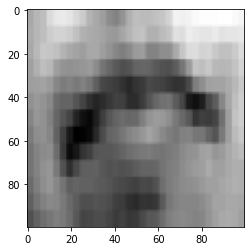

(1500, 10, 100, 100)


In [ ]:
x_train = np.array(x_train)
one =x_train[0][0]
print(one.shape)
plt.imshow(one,cmap='gray')
plt.show()
print(x_train.shape)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

print("X Training shape: ",x_train.shape)
print("X Test shape: ",x_test.shape)
print("X Validation shape: ",x_val.shape)
print("Y Training shape: ",y_train.shape)
print("Y Test shape: ",y_test.shape)
print("Y Validation shape: ",y_val.shape)

X Training shape:  (1500, 10, 100, 100)
X Test shape:  (0,)
X Validation shape:  (0,)
Y Training shape:  (1500,)
Y Test shape:  (0,)
Y Validation shape:  (0,)


In [ ]:
x =np.isnan(x_train).sum()
print(x)

0


In [ ]:
def normalize_it(X):
    v_min = X.min(axis=(2, 3), keepdims=True)
    v_max = X.max(axis=(2, 3), keepdims=True)
    #print(v_min)
    #print('Max: ',v_max)
    X = (X - v_min)/(v_max - v_min)
    X = np.nan_to_num(X)
    return X

In [ ]:
def clean(x_train,x_val,x_test,y_train,y_val,y_test):
    print()
    print("Normalizing data...")
    t1 = time.time()
    x_train = normalize_it(x_train)
    #print(X_train)
    x_val = normalize_it(x_val)
    x_test = normalize_it(x_test)
    t2 =time.time()
    print()
    print(f"Time taken to normalize images: {t2 - t1} secs")

    print()
    print("One hot encoding labels...")
    t3 = time.time()
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    y_val = np_utils.to_categorical(y_val, 10)
    t4 = time.time()
    print()
    print(f"Time taken to convert labels to categorical: {t4 - t3} secs")

    print()
    print("Shuffling data...")
    t5 = time.time()
    X_train, y_train = shuffle(x_train, y_train, random_state=0)
    X_test, y_test = shuffle(x_test, y_test, random_state=0)
    X_val, y_val = shuffle(x_val, y_val, random_state=0)
    t6 = time.time()
    print()
    print(f"Time taken to shuffle data: {t6 - t5} secs")
    
    print()
    print("Reshaping data...")
    t7 = time.time()
    x_train = np.expand_dims(x_train, axis=4)
    x_val = np.expand_dims(x_val, axis=4)
    x_test = np.expand_dims(x_test, axis=4)
    t8 = time.time()
    print()
    print(f"Time taken to reshape data: {t8 - t7} secs")
    print()

    print(x_train.shape)
    print(x_val.shape)
    print(x_test.shape)
    return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = clean(x_train,x_val,x_test,y_train,y_val,y_test)


Normalizing data...

Time taken to normalize images: 0.311004638671875 secs

One hot encoding labels...

Time taken to convert labels to categorical: 0.0001392364501953125 secs

Shuffling data...

Time taken to shuffle data: 0.06472086906433105 secs

Reshaping data...

Time taken to reshape data: 5.316734313964844e-05 secs

(90, 10, 100, 100, 1)
(10, 10, 100, 100, 1)
(30, 10, 100, 100, 1)


In [ ]:
'''

MODEL WITH 100% TRAINING ACCURACY

'''

model = Sequential()

model.add(Conv3D(32, (3, 3, 3), strides = 1, input_shape=(10, 100, 100, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(64, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))


shape = (1,10,10,128)
model.add((Flatten()))
model.add(Dense(10, activation='softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])
model.summary()

In [ ]:
plot_model(model,to_file='model.png')

In [ ]:
def myprint(s):
    with open('modelsummary.txt','a') as f:
        print(s, file=f)

model.summary(print_fn=myprint)

In [ ]:
  
t1 = time.time()
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks = [earlyStopping], epochs=45)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=35)
t2 = time.time()
print()
print(f"Training time : {(t2 - t1)/60} mins.")

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(1, 40)
# plt.ylim(0, 3)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
#pred = model.predict(x_test)
ypred = model.predict(x_test)
# predicted_words = [words[i] for i in np.argmax(ypred, axis=1)]
# actual_words = [words[i] for i in np.argmax(y_test,axis=1)]
predicted_words = [words[i] for i in np.argmax(ypred, axis=1)]
actual_words = [words[i] for i in np.argmax(y_test,axis=1)]
#actual_words = [words[i] for i in np.argmax(y_train,axis=1)]


1/1 [==============================] - 0s 272ms/step


In [ ]:
correct = 0
for p, a in zip(predicted_words, actual_words):
    if p == a:
        correct += 1
    print(f"Predicted : {p} \t Actual : {a}")

accuracy = correct/len(actual_words)
print()
print()
print(f"Accuracy = {accuracy*100}% on testing data")